# Une approche spectrale à la détection de communautés ###
Examples étape-par-étape à la détection de communautés sur un graphe avec des outils d'algèbre linéaire.

In [2]:
# imports, note scipy>=1.8 est nécessaire
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
import collections
from matplotlib.ticker import MaxNLocator
import community
import statistics as stats
from collections import Counter
import seaborn as sns
from matplotlib import rc
import pandas as pd
import csv
import sklearn.cluster
import scipy
import plotly
import plotly.graph_objs as go

## 2 communautés - exemple du club de Karaté

Charge le graphe et l'affiche en utilisant une disposition "spring".

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


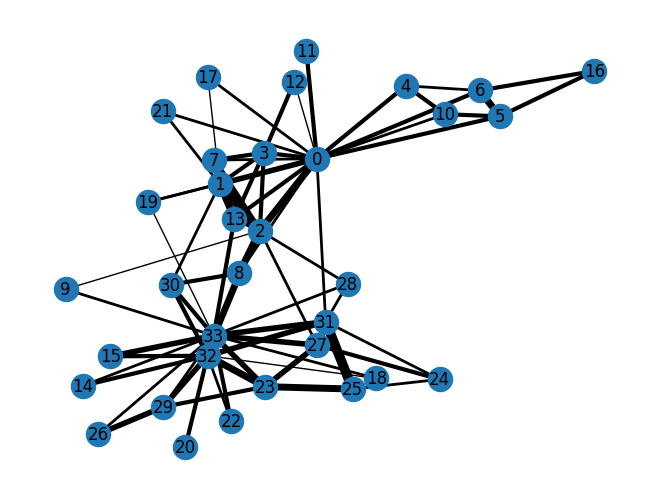

In [3]:
G_karate = nx.karate_club_graph()
pos = nx.spring_layout(G_karate)
weight_of_edges = list(nx.get_edge_attributes(G_karate, "weight").values())
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos, width=weight_of_edges)
plt.savefig('GraphBase.png')
plt.show()

Calcule et utilise le vecteur de Fiedler pour diviser le graphe en deux communautés.

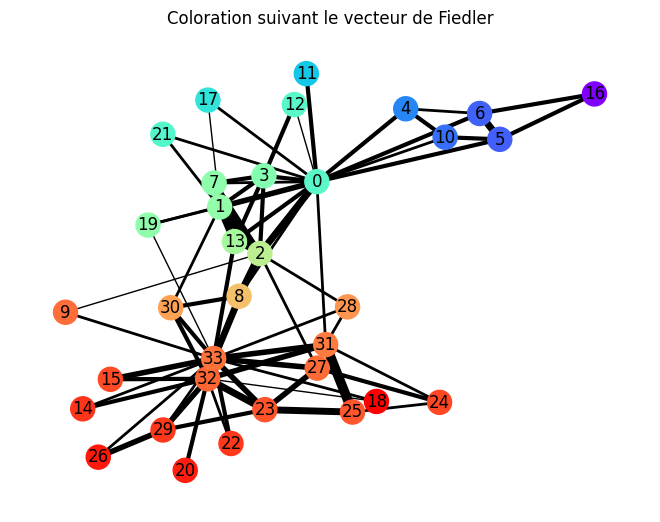

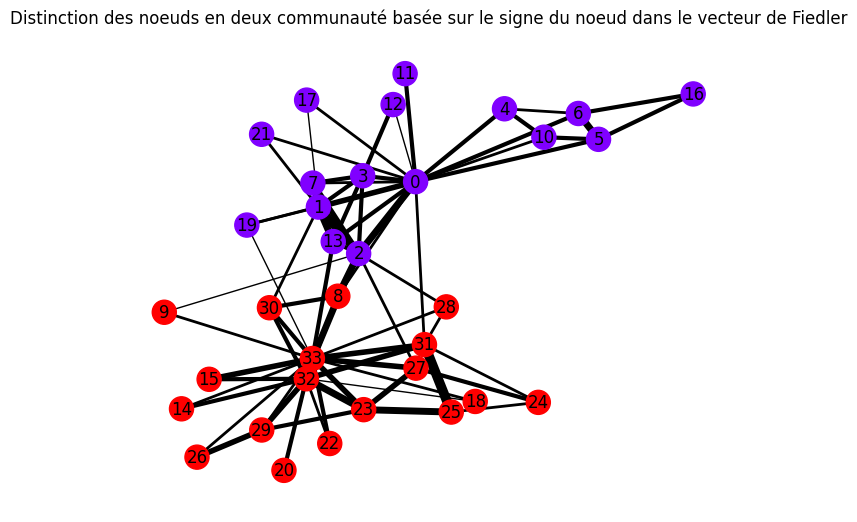

In [4]:
# Calcule le vecteur de Fiedler et le représente sur le graphe
fiedler_vector = nx.fiedler_vector(G_karate)
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos, width=weight_of_edges, node_color = fiedler_vector)
plt.title('Coloration suivant le vecteur de Fiedler')
plt.show()

# séparer en communautés en fonction des signes dans le vecteur de Fiedler.
partitions = fiedler_vector>0
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos, width=weight_of_edges, node_color = partitions)
plt.title("Distinction des noeuds en deux communauté basée sur le signe du noeud dans le vecteur de Fiedler")
plt.show()

### 4 communautés - exemple d'un "Stochastic Block Model"

Crée de manière aléatoire un graphe avec 4 bloques fortement intra-connectés et faiblement inter-connectés.

probabilité d'une arête entre les blocks : [[0.9, 0.1, 0.1, 0.1], [0.1, 0.9, 0.1, 0.1], [0.1, 0.1, 0.9, 0.1], [0.1, 0.1, 0.1, 0.9]]


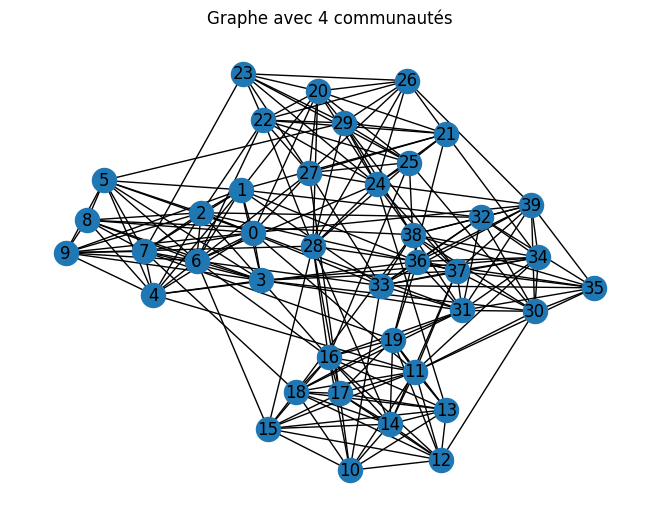

In [5]:
P = [[0.9 if i==j else 0.1 for j in range(4)]for i in range(4)]
print("probabilité d'une arête entre les blocks : "+str(P))
G = nx.stochastic_block_model([10,10,10,10], P)

# visualize the graph
nx.draw(G, with_labels=True)
plt.title("Graphe avec 4 communautés")
plt.show()

Calcule et affiche le Laplacien et ses propriétés spectrales. Par rapport au cours, la définition alternative du Laplacien est prise L=D-A, plutôt que L=A-D. Ce choix est sans conséquences sur la détection de communautés faîte après.

In [6]:
# spectral quantities of interest
print('Matrice d adjacence : ')
print(nx.adjacency_matrix(G).todense())

print('\nLaplacien : ')
print(nx.laplacian_matrix(G).todense())

print('\nDécomposition spectrale du Laplacien L = V * D * V^T')
D,V = scipy.linalg.eig(nx.laplacian_matrix(G).todense())

print('\nValeur propres D')
print(D)

print('\nVecteurs propres V')
print(V)

print('\nRevenir au Laplacien V * D * V^T')
print(np.matmul(np.matmul(V,np.diag(D)),np.transpose(V)))

Matrice d adjacence : 
[[0 1 1 ... 1 0 1]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [1 0 0 ... 1 1 0]]

Laplacien : 
[[14 -1 -1 ... -1  0 -1]
 [-1 13 -1 ...  0  0  0]
 [-1 -1 13 ...  0  0  0]
 ...
 [-1  0  0 ... 12 -1 -1]
 [ 0  0  0 ... -1 11 -1]
 [-1  0  0 ... -1 -1 14]]

Décomposition spectrale du Laplacien L = V * D * V^T

Valeur propres D
[-4.44089210e-16+0.j  2.78213840e+00+0.j  3.48767641e+00+0.j
  4.25579611e+00+0.j  1.78836018e+01+0.j  1.73246922e+01+0.j
  1.64519078e+01+0.j  1.62332139e+01+0.j  1.58161261e+01+0.j
  1.56730690e+01+0.j  1.53317909e+01+0.j  8.32015096e+00+0.j
  1.50118920e+01+0.j  1.45362469e+01+0.j  1.43777805e+01+0.j
  1.42772926e+01+0.j  8.90960033e+00+0.j  9.10953004e+00+0.j
  1.37136907e+01+0.j  9.34790538e+00+0.j  9.52667180e+00+0.j
  1.34489083e+01+0.j  1.32484103e+01+0.j  9.78197391e+00+0.j
  9.96668306e+00+0.j  1.00854612e+01+0.j  1.30069434e+01+0.j
  1.27973778e+01+0.j  1.27315972e+01+0.j  1.22713088e+01+0.j
  1.2

Chaque ligne de V est associée à un noeud, et chaque colonne à une valeur propre. Notez que la première colonne correspond à la valeur propre nulle avec un vecteur propre constant sur les noeuds (toujours le cas en partant d'un Laplacien).

On peut utiliser les autres colonnes pour définir un vecteur associé à chaque noeud. Représentons le vecteur à 2 dimension obtenu en prennant la deuxième et troisième colonnes.

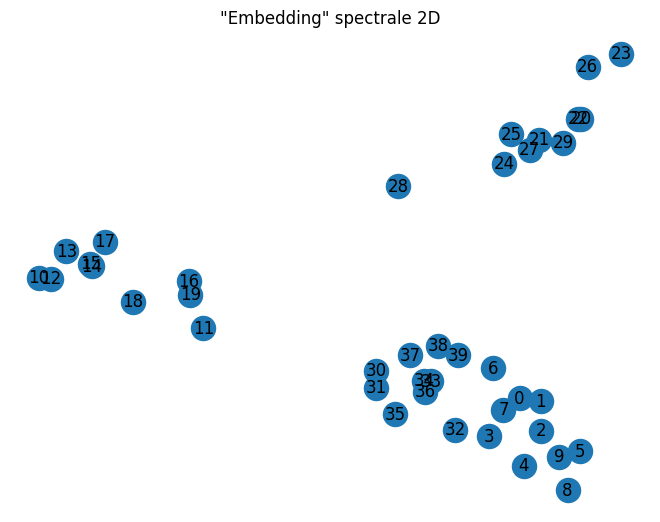

In [7]:
# Visualisation des noeuds en utilisant le vecteur spectral à 2-dimensions.
# parfois pas assez informatif pour dériver 4 communautés
nx.draw_spectral(G, with_labels=True, edgelist=[])
plt.title("\"Embedding\" spectrale 2D")
plt.show()

Maintenant si on ajoute les arête à l'affichage, on obtient.

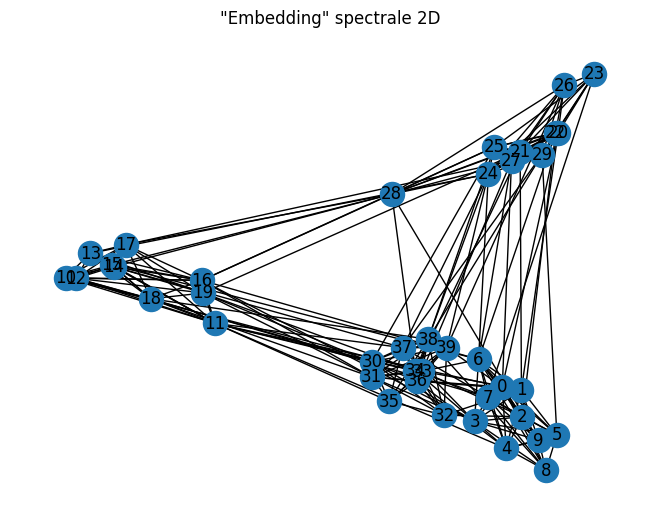

In [8]:
nx.draw_spectral(G, with_labels=True)
plt.title("\"Embedding\" spectrale 2D")
plt.show()

Comme vous pouvez le constater, cet embedding 2D basé sur la matrice V révèle la structure des communautés dans le graphe. Cependant, nous devrions clairement observer 4 communautés. En fonction du graphe généré de manière aléatoire, cela peut être difficile à percevoir. Si nous ajoutons une dimension d'embedding avec une colonne supplémentaire de V, nous pouvons corriger le problème.

In [9]:
# Graphique de l'embedding tridimensionnel des nœuds, nous pouvons voir 4 "clusters" évidents.

spectral_coords = nx.spectral_layout(G, dim=3)
spectral_coords = list(zip(*spectral_coords.values()))

trace = go.Scatter3d(
    x=spectral_coords[0], 
    y=spectral_coords[1], 
    z=spectral_coords[2], 
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

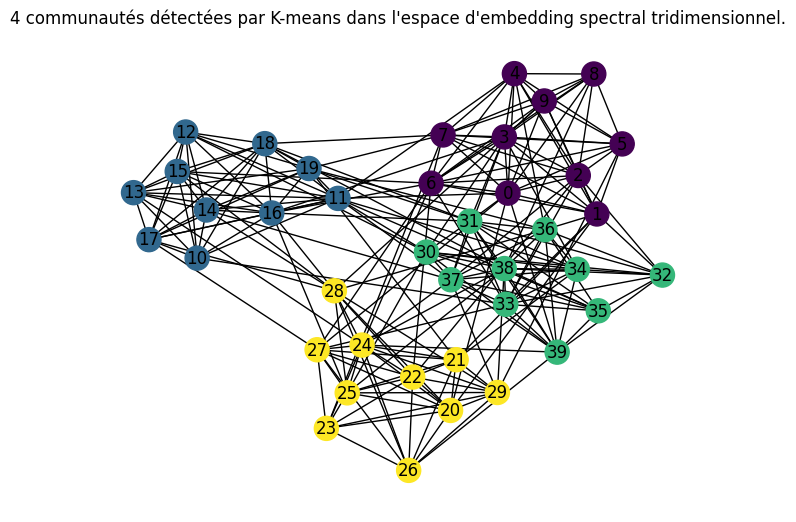

In [10]:
# Dans l'espace d'embedding tridimensionnel, regroupe les nœuds en 4 "clusters" avec K-Means, puis déduit les communautés.
spectral_coords = nx.spectral_layout(G, dim=3)
partitions = sklearn.cluster.KMeans(n_clusters=4).fit_predict([spectral_coords[node] for node in G.nodes()])
nx.draw(G, with_labels=True, node_color = partitions)
plt.title("4 communautés détectées par K-means dans l'espace d'embedding spectral tridimensionnel.")
plt.show()